# OUTLIER NOTEBOOK

In [3]:
import sys
sys.path.append("../notebooks/scripts/")

In [4]:
import altair as alt
from altair_saver import save
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [5]:
alt.renderers.set_embed_options(
    padding={"left": 0, "right": 0, "bottom": 1, "top": 1}
)

RendererRegistry.enable('default')

In [6]:
sns.set_style("ticks")
# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 100
# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 8
mpl.rc('text', usetex=False)

In [7]:
try: 
    snakemake.input.node_df
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Snakemake Specific Variables

In [380]:
try:
    node_df = snakemake.input.node_df

    pca_df = snakemake.input.pca_df
    explained_variance_pca = snakemake.input.explained_variance_pca

    mds_df = snakemake.input.mds_df

    #KDE Density:

    KDE_mds = snakemake.input.KDE_mds
    KDE_mds_metadata = snakemake.input.KDE_mds_metadata

except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


In [381]:
domain =  ['outlier', 'not_outlier'] 
range_ = ['#FF0000','#000000']

# Reading in all the data from the scripts

In [382]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/outlier_analysis'

In [383]:
#node_df = pd.read_csv(node_df, sep="\t")
metadata_df = pd.read_csv("results/total_metadata.tsv", sep="\t")
node_df = pd.read_csv("results/table.tsv", sep="\t")

In [384]:
metadata_df

strain        date accession country region  \
0                    A/Alabama/01/2017  2017-01-04  CY216617     USA      N   
1                    A/Alabama/02/2015  2015-01-26  KT836052     USA      N   
2                    A/Alabama/02/2016  2016-01-27  KX412662     USA      N   
3                    A/Alabama/02/2017  2017-01-05  CY216609     USA      N   
4                    A/Alabama/03/2017  2017-01-19  CY216625     USA      N   
...                                ...         ...       ...     ...    ...   
9573   A/swine/Virginia/A02478454/2019  2019-04-26  MK967619     USA      N   
9574   A/swine/Virginia/A02478581/2019  2019-04-22  MN436839     USA      N   
9575   A/swine/Virginia/A02478738/2019  2019-08-29  MN608561     USA      N   
9576  A/swine/Wisconsin/A02140875/2018  2018-01-19  MG977436     USA      N   
9577    A/swine/Wyoming/A02245222/2019  2019-08-23  MN543888     USA      N   

          outlier  
0     not_outlier  
1     not_outlier  
2     not_outlier  
3     not_outlier  
4     not_outlier  
...           ...  
9573      outlier  
9574      outlier  
9575      outlier  
9576      outlier  
9577      outlier  

[9578 rows x 6 columns]

In [385]:
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [386]:
node_df.head()

strain     date  pca1  pca2  pca3  pca4  \
0     A/swine/Minnesota/A01785788/2018  2018.95  5.07 -0.68  5.79  4.72   
1  A/swine/BritishColumbia/SD0286/2018  2018.27  4.99  1.09  4.89  7.37   
2     A/swine/Saskatchewan/SD0271/2018  2018.18  4.92  1.34  5.02  7.07   
3          A/swine/Manitoba/D0524/2018  2018.05  5.73 -1.07  4.78  5.65   
4      A/swine/Nebraska/A02256553/2018  2018.62  6.13 -0.13  4.59  5.08   

     mds1    mds2  tsne_x  tsne_y  umap_x  umap_y clade_membership  pca_label  \
0  134.07 -162.40   -6.03    6.34    4.12   25.35       unassigned          0   
1  188.91 -113.46   -5.95    5.19    4.18   25.14       unassigned          0   
2  192.03   91.91   -5.96    5.20    4.28   25.13       unassigned          0   
3  -24.46  207.28   -5.05    6.89    4.04   25.35       unassigned          0   
4  129.52  176.69   -5.09    7.28    4.07   25.07       unassigned          0   

   mds_label  umap_label  t-sne_label  y  
0         -1           2           18  1  
1         -1           2           18  2  
2         -1           2           18  3  
3         -1           2           18  4  
4         -1           2           18  5

In [387]:
node_df = node_df.merge(metadata_df[["strain", "outlier"]], on="strain")

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [388]:
#principalDf = pd.read_csv(pca_df, index_col=0)
principalDf = pd.read_csv("results/embed_pca.csv", index_col=0)

In [389]:
#explained_variance_df = pd.read_csv(explained_variance_pca)
explained_variance_df = pd.read_csv("results/explained_variance_pca.csv")
explained_variance_df

explained variance  principal components
0              0.1828                     1
1              0.1284                     2
2              0.1035                     3
3              0.0763                     4
4              0.0675                     5
5              0.0373                     6
6              0.0227                     7
7              0.0208                     8
8              0.0175                     9
9              0.0161                    10

Text(0.5, 1.0, 'Explained Variance Plot (Flu)')

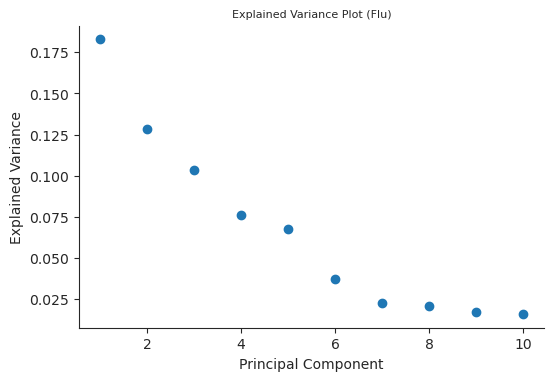

In [390]:
plt.plot(explained_variance_df['principal components'].values.tolist(), explained_variance_df["explained variance"].values.tolist(), 'o')

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

plt.title(f"Explained Variance Plot (Flu)")

#plt.savefig(snakemake.output.Explained_variance_PCA)

In [391]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "outlier"]], on="strain")

In [392]:
merged_pca_df.head()

strain      pca1      pca2      pca3      pca4       pca5  \
0  A/swine/IA/34208/2018  4.711257  0.132028  3.828310  3.674044  10.088116   
1     A/Shiraz/1006/2015  4.107369  0.330365  2.316354  2.571992   8.137740   
2      A/Alabama/15/2016 -1.364820 -1.750137 -0.029657 -1.102026  -0.039830   
3    A/NewJersey/26/2016 -1.365359 -1.750497 -0.054033 -1.097152  -0.033953   
4     A/Michigan/07/2017 -1.365484 -1.747739 -0.053140 -1.094311  -0.029262   

       pca6      pca7      pca8      pca9     pca10  pca_label     date     y  \
0 -1.375005 -0.695145  0.773117  1.025409  2.402932         -1  2018.35    23   
1 -0.293806  0.157680  1.089866  0.404024  2.614539          0  2015.81    24   
2 -0.415751 -0.909012 -0.810051 -0.186329  0.408032         21  2016.88  1888   
3 -0.416880 -0.902263 -0.806463 -0.250444  0.413471         21  2016.88  1891   
4 -0.415310 -0.898625 -0.804398 -0.248012  0.429472         21  2017.03  1887   

       outlier  
0      outlier  
1  not_outlier  
2  not_outlier  
3  not_outlier  
4  not_outlier

In [393]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [394]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "outlier:N",['strain', "outlier"], domain, range_)
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("../docs/PCAOutlierBrush.html")

alt.HConcatChart(...)

# Running MDS on the Dataset

In [395]:
MDS_df = pd.read_csv("results/embed_mds.csv",index_col=0)
outlier_df = pd.read_csv("results/outliers.csv")

In [396]:
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "outlier"]], on="strain")

In [397]:
merged_mds_df = merged_mds_df.merge(outlier_df[['strain', 'predicted_outlier_status']], on="strain")

In [398]:
merged_mds_df

strain        mds1        mds2  mds_label  \
0                   A/swine/IA/34208/2018  165.129917   38.058226         -1   
1                      A/Shiraz/1006/2015   15.209952 -110.414412         -1   
2                       A/Alabama/15/2016   -6.483664    8.174998          9   
3                     A/NewJersey/26/2016   -6.483850    8.175839          9   
4                      A/Michigan/07/2017   -7.695796    8.553672         -1   
...                                   ...         ...         ...        ...   
2593      A/swine/Virginia/A01785950/2019  143.770377  164.484536         -1   
2594          A/swine/Ontario/SD0298/2018  207.935677  -11.770534         -1   
2595  A/swine/BritishColumbia/SD0286/2018  188.905598 -113.460845         -1   
2596     A/swine/Saskatchewan/SD0271/2018  192.032535   91.909391         -1   
2597     A/swine/Minnesota/A01785788/2018  134.072626 -162.400055         -1   

         date     y      outlier  predicted_outlier_status  
0     2018.35    23      outlier                      -1.0  
1     2015.81    24  not_outlier                       1.0  
2     2016.88  1888  not_outlier                       1.0  
3     2016.88  1891  not_outlier                       1.0  
4     2017.03  1887  not_outlier                       1.0  
...       ...   ...          ...                       ...  
2593  2019.10     8      outlier                       1.0  
2594  2018.33     6      outlier                      -1.0  
2595  2018.27     2      outlier                      -1.0  
2596  2018.18     3      outlier                       1.0  
2597  2018.95     1      outlier                      -1.0  

[2598 rows x 8 columns]

In [399]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','outlier'],'outlier:N', domain, range_)
#chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds3','mds4',"mds3","mds4",['strain','outlier'],'outlier:N', domain, range_)
#chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds5','mds6',"mds5","mds6",['strain','outlier'],'outlier:N', domain, range_)
chart_12_mds#|chart_34_mds|chart_56_mds

alt.Chart(...)

<AxesSubplot:xlabel='mds1'>

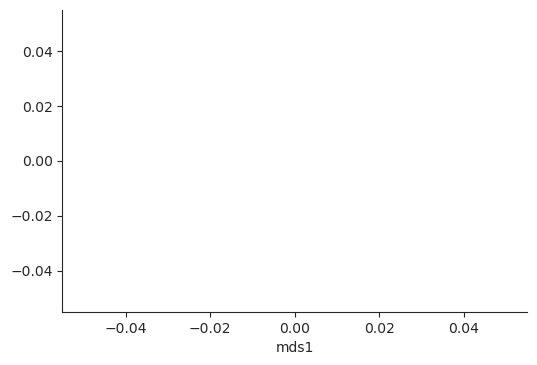

In [374]:
import numpy as np
import matplotlib.pyplot as pp

chart1 = alt.Chart(merged_mds_df).mark_circle(size=60).encode(
    x='outlier_status',
    color='outlier:N',
    tooltip=['strain']
).interactive()


chart2 = alt.Chart(merged_mds_df).mark_circle(size=60).encode(
    x='outlier_status',
    color='y_predicted:N',
    tooltip=['strain', "outlier:N"]
).interactive()

chart1|chart2

In [359]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'outlier:N', ['strain','outlier'], domain, range_)
list_of_chart[0]|list_of_chart[1]

alt.HConcatChart(...)

In [360]:
mapping = {'not_outlier': 1, 'outlier': -1}

merged_mds_df = merged_mds_df.replace({'not_outlier': mapping, 'outlier': mapping})

In [361]:
domain =  ['-1', '1'] 
range_ = ['#FF0000','#000000']

In [371]:
merged_mds_df['outlier'].value_counts()

 1    2561
-1      37
Name: outlier, dtype: int64

In [363]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','outlier'],'predicted_outlier_status:N', domain, range_)
chart_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','outlier'],'outlier:N', domain, range_)
chart_12_mds|chart_mds

alt.HConcatChart(...)

In [364]:
from sklearn.metrics import accuracy_score
accuracy_score(merged_mds_df["outlier"].values.tolist(), merged_mds_df["predicted_outlier_status"].values.tolist())

0.9884526558891455

In [365]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef
matthews_corrcoef(merged_mds_df["outlier"].values.tolist(), merged_mds_df["predicted_outlier_status"].values.tolist())

0.5322470899753056

In [366]:
confusion_matrix(merged_mds_df["outlier"].values.tolist(), merged_mds_df["predicted_outlier_status"].values.tolist())

array([[  17,   20],
       [  10, 2551]])

In [8]:
MDS_KDE_df = pd.read_csv("results/KDEDensity_mds.csv",index_col=0)
MDS_KDE_metadata_df = pd.read_csv("results/KDEDensity_mds_metadata.csv", index_col=0)
MDS_outlier_metadata_df = pd.read_csv("results/LOF_accuracy.csv")

/home/nandsra21/anaconda3/envs/cartography/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
import pandas as pd

In [6]:
full_outlier = pd.read_csv("results/outliers_full.csv")

In [7]:
full_outlier

strain        mds1        mds2  \
0                       A/Geneva/A9509/1995   40.057960 -108.093833   
1                         A/HongKong/3/1995   40.986082 -106.682756   
2                     A/Malaysia/07145/1995   39.352328 -109.969310   
3                     A/Malaysia/07832/1995   23.108163 -115.866848   
4                        A/NewYork/625/1996   40.383057 -109.040941   
...                                     ...         ...         ...   
5861  A/environment/Indiana/16TOSU3546/2016 -115.384596 -141.539185   
5862  A/environment/Indiana/16TOSU3553/2016 -114.509101 -140.943673   
5863                       A/Kansas/13/2009  -76.009146 -136.187595   
5864            A/Guangdong/YueFang277/2017 -104.987894  -29.048543   
5865                 A/HoChiMinh/459.6/2010   81.867968  -35.783725   

      mds_label  predicted_outlier_status  predicted_LOF_outlier_status  \
0             2                         1                             1   
1             2                         1                             1   
2             2                         1                             1   
3            -1                         1                             1   
4             2                         1                             1   
...         ...                       ...                           ...   
5861         -1                        -1                            -1   
5862         -1                        -1                            -1   
5863         -1                        -1                            -1   
5864         -1                        -1                            -1   
5865         -1                        -1                            -1   

       X_scores  
0     -1.096521  
1     -0.995140  
2     -1.333372  
3     -1.191766  
4     -1.138899  
...         ...  
5861 -19.352632  
5862 -19.215711  
5863 -14.558127  
5864 -10.018745  
5865 -10.877924  

[5866 rows x 7 columns]

In [10]:
import altair as alt
alt.data_transformers.disable_max_rows()
chart1 = alt.Chart(full_outlier).mark_circle(size=60).encode(
            x=alt.X('X_scores', title="X_scores"),
            color='predicted_outlier_status:N',
            tooltip=['strain']
        )
chart1

alt.Chart(...)

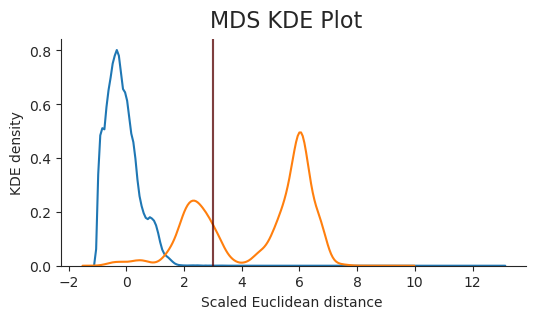

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=MDS_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax.axvline(x=MDS_outlier_metadata_df["threshold"].values.tolist()[0], label="Outlier threshold", color="#800000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance ")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [400]:
TSNE_df = node_df[["strain", "date", "y", "outlier", "tsne_x", "tsne_y", "t-sne_label"]]

In [401]:
scatterplot_with_tooltip_interactive(TSNE_df,'tsne_x','tsne_y','tsne_x','tsne_y',['strain', "outlier"],'outlier:N', domain, range_)

alt.Chart(...)

In [402]:
list_of_chart = linking_tree_with_plots_brush(
    TSNE_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'outlier:N',
    ["strain:N"],
    domain,
    range_
)
chart_tsne = list_of_chart[0]|list_of_chart[1]
chart_tsne

alt.HConcatChart(...)

# Running UMAP on the Dataset

In [403]:
UMAP_df = node_df[["strain", "date", "y", "outlier", "umap_x", "umap_y"]]

In [404]:
scatterplot_with_tooltip_interactive(UMAP_df,'umap_x','umap_y','umap_x','umap_y',['strain'],'outlier:N', domain, range_)

alt.Chart(...)

In [405]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    UMAP_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'outlier:N',
    ["strain:N"],
    domain,
    range_
)
chart_umap = list_of_chart[0]|list_of_chart[1]
chart_umap
#chart.save("../docs/UMAPMERSBrush.html")

alt.HConcatChart(...)

# Linking all plots together clickable with Tree

In [406]:
data = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'outlier:N',
    ['strain'],
    domain,
    range_
)

In [407]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.vconcat(data[0],embeddings)
fullChart
#fullChart.save("../docs/FullLinkedChartBrushableFluOutlier.html")
#fullChart
#fullChart.save(snakemake.output.fullChart)
#save(fullChart, "../docs/FullLinkedChartBrushableFluOutlier.png", scale_factor=2.0)
#save(fullChart, snakemake.output.fullChartPNG, scale_factor=2.0)

alt.VConcatChart(...)